# Numerical methods: Scipy

*Davide Gerosa (Milano-Bicocca)*

**Sources**: Michael Zingale at Stony Brook University: https://sbu-python-class.github.io

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Scipy is a collection of numerical algorithms with python interfaces.  In many cases, these interfaces are wrappers around standard numerical libraries that have been developed in the community and are used with other languages.  Usually, detailed references are available to explain the implementation.

There are many subpackages generally, you load the subpackages separately, e.g.

```
from scipy import linalg, optimize
```
and you have access to the methods in those namespaces.


## Numerical Methods 

One thing to keep in mind -- all numerical methods have strengths and weaknesses, and make assumptions.  You should **always** do some research into the method to understand what it is doing.

It is also always a good idea to run a new method on some test where you know the answer, to make sure it is behaving as expected.

Scipy has *a lot* to offer. In these notes:
 - Integration
 - Interpolation
 - Root finding
 - ODE (Cauchy problems)
 - ODE (Boundary value problems)
 - Fitting
 - Fourier transforms
 - Linear algebra
 
 (something that I won't cover here but it's immensely useful is `scipy.stats`)

## Integration

We'll do some integrals of the form

$$I = \int_a^b f(x) dx$$

We can imagine two situations:
* Our function $f(x)$ is given by an analytic expression.  This gives us the freedom to pick our integration points, and in general can allow us to optimize our result and get high accuracy
* Our function $f(x)$ is defined on at a set of (possibly regular spaced) points.  

In numerical analysis, the term _quadrature_ is used to describe any integration method that represents the integral as the weighted sum of a discrete number of points.

In [2]:
from scipy import integrate
#help(integrate)

Let's consider integrating

$$I = \int_0^{2\pi} \sin^2(x) dx$$

`quad` is the basic integrator for a general (not sampled) function.  It uses a general-interface from the Fortran package QUADPACK (QAGS or QAGI).  It will return the integral in an interval and an estimate of the error in the approximation

In [3]:
def f(x):
    return np.sin(x)**2

In [4]:
#help(integrate.quad)

`quad` will return the integral and an estimate of the error.  We can seek more accuracy by setting `epsabs` and `epsrel`,
but remember that we can't do better than roundoff error.

In [5]:
I, err = integrate.quad(f, 0.0, 2.0*np.pi, epsabs=1.e-7, epsrel=1.e-7)
print(I)
print(err)

3.1415926535897927
2.305879276310235e-09


In [6]:
#help(integrate.quad)

### Additional arguments

Sometimes our integrand function takes optional arguments.  Let's consider integrating

$$g(x) = A e^{-(x/\sigma)^2}$$

now we want to be able to define the amplitude, $A$, and width, $\sigma$ as part of the function.

In [7]:
def g(x, A, sigma):
    return A*np.exp(-x**2/sigma**2)

In [8]:
I, err = integrate.quad(g, -1.0, 1.0, args=(1.0, 2.0))
print(I, err)

1.8451240256511698 2.0484991765669867e-14


### Integrating to infinity

Numpy defines the `inf` quantity which can be used in the integration limits.  We can integrate a Gaussian over $[-\infty, \infty]$ (we know the answer
is $\sqrt{\pi}$).

Note: behind the scenes, what the integration function does is do a variable transform like: $t = 1/x$.  This works when one limit is $\infty$, giving

$$\int_a^b f(x) dx = \int_{1/b}^{1/a} \frac{1}{t^2} f\left (\frac{1}{t}\right) dt$$

In [9]:
I, err = integrate.quad(g, -np.inf, np.inf, args=(1.0, 1.0))
print(I, err)
print(np.pi**0.5)
print(abs(I-np.pi**0.5)) #Remember 0 in a computer always means "0 within machine epsilon"

1.7724538509055159 1.4202637059452923e-08
1.7724538509055159
0.0


### Multidimensional integrals

Multidimensional integration can be done with successive calls to quad(), but there are wrappers that help

Let's compute 

$$I = \int_{y=0}^{1/2} \int_{x=0}^{1-2y} xy dxdy = \frac{1}{96}$$

(this example comes from the scipy tutorial)

Notice that the limits of integration in $x$ depend on $y$.

Note the form of the function:

```
dblquad(f, a, b, xlo, xhi)
```
where `f` = `f(y, x)` -- the y argument is first

The integral will be from: $y = [0, 1/2]$, and $x$ = `xlo(y)`, $x$ = `xhi(y)`

In [10]:
def integrand(y, x):
    return x*y

def x_lower_lim(y):
    return 0
    
def x_upper_lim(y):
    return 1-2*y

# we change the definitions of x and y in this call
I, err = integrate.dblquad(integrand, 0.0, 0.5, x_lower_lim, x_upper_lim)
print(I, err)


0.010416666666666668 4.1016201284723663e-16


If you remember the python lambda functions (one-shot functions), you can do this more compactly:

In [11]:
I, err = integrate.dblquad(lambda y, x: x*y, 0.0, 0.5, lambda y: 0, lambda y: 1-2*y)
print(I)

0.010416666666666668


### Integration of a sampled function

Here we integrate a function that is defined only at a sequence of points.  Recall that Simpson's rule will use piecewise parabola data.  Let's compute

$$I = \int_0^{2\pi} f(x_i) dx$$

with $x_i = 0, \ldots, 2\pi$ defined at $N$ points

In [14]:
N = 17
x = np.linspace(0.0, 2.0*np.pi, N, endpoint=True)
y = np.sin(x)**2

I = integrate.simpson(y, x=x)
print(I)

3.141592653589793


Romberg integration is specific to equally-spaced samples, where $N = 2^k + 1$  and converge faster (it uses extrapolation of coarser integration results to achieve higher accuracy)

In [15]:
N = 17
x = np.linspace(0.0, 2.0*np.pi, N, endpoint=True)
y = np.sin(x)**2

I = integrate.romb(y, dx=x[1]-x[0])
print(I)

3.1430658353300385


<div class="alert alert-block alert-warning">
    
<span class="fa fa-flash"></span> Quick Exercise:

Compute the same integral using a Monte Carlo estimator and numpy.mean.
    
</div>

## Interpolation

Interpolation fills in the gaps between a discrete number of points by making an assumption about the behavior of the functional form of the data. The same thing in the machine-learning world is sometimes called "emulation". 

Many different types of interpolation exist
* some ensure no new extrema are introduced
* some conserve the quantity being interpolated
* some match derivative at endpoints

Pathologies exist -- it is not always best to use a high-order polynomial to pass through all of the points in your dataset.

The `interp1d()` function allows for a variety of 1-d interpolation methods.  It returns an object that acts as a function, which can be evaluated at any point.

In [16]:
import scipy.interpolate as interpolate

In [17]:
#help(interpolate.interp1d)

Let's sample 

$$f(x) = x \sin(x)$$

and try to interpolate it.

In [18]:
def f_exact(x):
    return np.sin(x)*x

In [19]:
N = 10
x = np.linspace(0, 20, N)

y = f_exact(x)

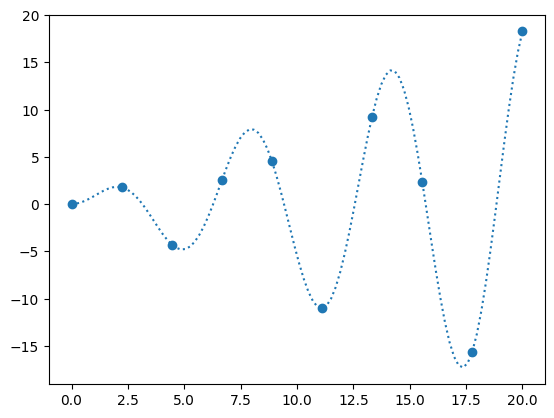

In [20]:
fig, ax = plt.subplots()

x_fine = np.linspace(0, 20, 10*N)

ax.scatter(x, y)
ax.plot(x_fine, f_exact(x_fine), ls=":", label="original function")

When we create an interpolant via `interp1d`, it creates a function object

In [21]:
f_interp = interpolate.interp1d(x, y, kind="cubic")

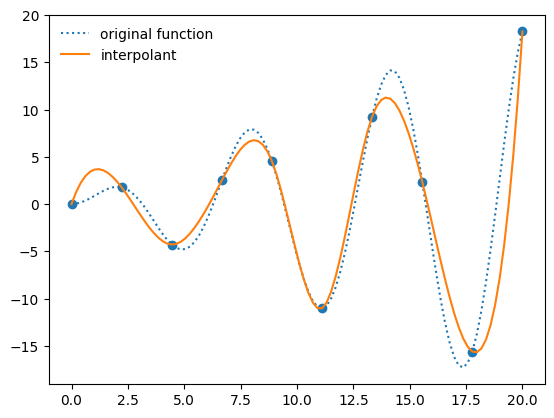

In [22]:
ax.plot(x_fine, f_interp(x_fine), label="interpolant")

ax.legend(frameon=False, loc="best")
fig

### Multi-d interpolation

Here's an example of mult-d interpolation from the official tutorial.

First we define the "answer" -- this is the true function that we will sample at a number of points and then try to use interpolation to recover

In [23]:
def func(x, y):
    return x*(1-x)*np.cos(4*np.pi*x) * np.sin(4*np.pi*y**2)**2

Here will use mgrid to create the grid of (x,y) where we know func exactly -- this will be for plotting.  Note the fun trick here, this is not really a function, but rather something that can magically look like an array, and we index it with the start:stop:stride.  If we set stride to an imaginary number, then it is interpreted as the number of points to put between the start and stop

In [24]:
grid_x, grid_y = np.mgrid[0:1:100j, 0:1:200j]

In [25]:
print(grid_x.shape)
print(grid_y.shape)

(100, 200)
(100, 200)


Here's what the exact function looks like -- note that our function is defined in x,y, but imshow is meant for plotting an array, so the first index is the row.  We take the transpose when plotting

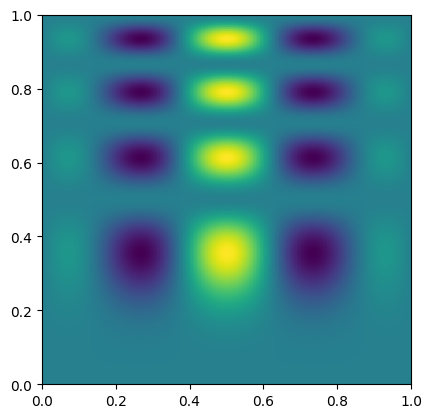

In [26]:
fig, ax = plt.subplots()
ax.imshow(func(grid_x, grid_y).T, extent=(0,1,0,1), origin="lower")

Now we'll define 1000 random points where we'll sample the function

In [27]:
points = np.random.rand(1000, 2)
values = func(points[:,0], points[:,1])

Here's what those points look like:

(0.0, 1.0)

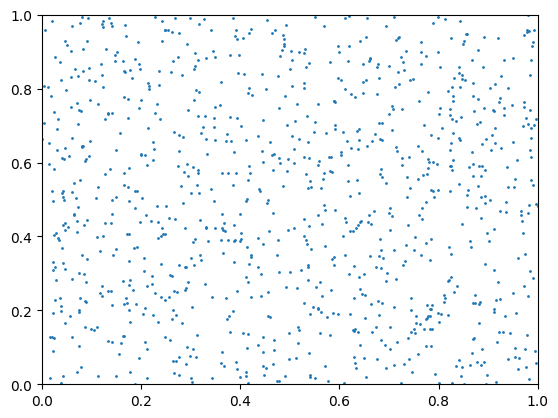

In [28]:
fig, ax = plt.subplots()
ax.scatter(points[:,0], points[:,1], s=1)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

The interpolate.griddata() function provides many ways to interpolate a collection of points into a uniform grid.  There are many different interpolation methods within this function

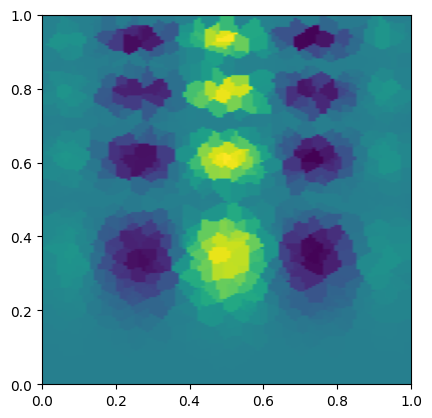

In [29]:
grid_z0 = interpolate.griddata(points, values, (grid_x, grid_y), method='nearest')

fig, ax = plt.subplots()
ax.imshow(grid_z0.T, extent=(0,1,0,1), origin="lower")

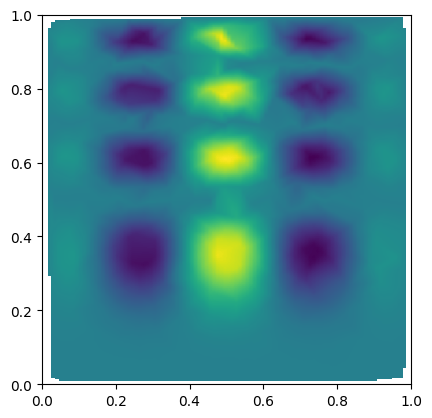

In [30]:
grid_z0 = interpolate.griddata(points, values, (grid_x, grid_y), method='linear')

fig, ax = plt.subplots()
ax.imshow(grid_z0.T, extent=(0,1,0,1), origin="lower")

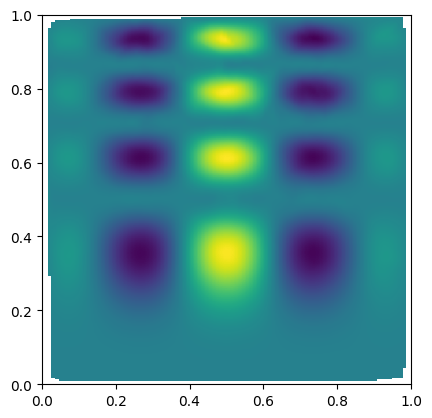

In [31]:
grid_z0 = interpolate.griddata(points, values, (grid_x, grid_y), method='cubic')

fig, ax = plt.subplots()
ax.imshow(grid_z0.T, extent=(0,1,0,1), origin="lower")

## Root Finding

Often we need to find a value of a variable that zeros a function -- this is _root finding_.  Sometimes, this is a multidimensional problem.

The `brentq()` routine offers a very robust method for find roots from a scalar function.  You do need to provide an interval that bounds the root.

Let's consider:

$f(x) = \frac{x e^x}{e^x - 1} - 5$

(this is the non-linear equation that comes up in deriving [Wien's law for radiation](https://en.wikipedia.org/wiki/Wien%27s_displacement_law))

In [32]:
import scipy.optimize as optimize

In [33]:
def f(x):
    return (x*np.exp(x)/(np.exp(x) - 1.0) - 5.0)

In [34]:
root, r = optimize.brentq(f, 0.1, 10.0, full_output=True)

print(root)
print(r.converged)

4.965114231744287
True


In [35]:
r?

/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_68074/299635026.py:2: RuntimeWarning: invalid value encountered in divide
  return (x*np.exp(x)/(np.exp(x) - 1.0) - 5.0)


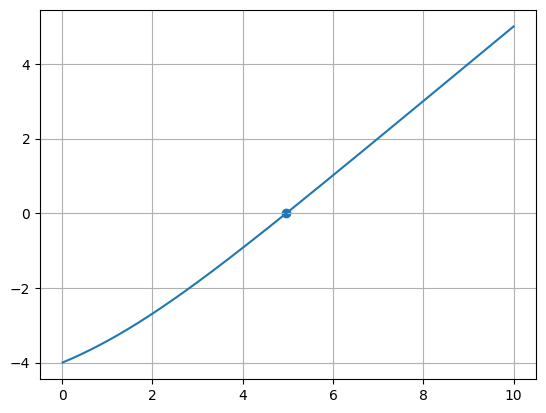

In [36]:
x = np.linspace(0., 10.0, 1000)
fig, ax = plt.subplots()
ax.plot(x, f(x))
ax.scatter(np.array([root]), np.array([f(root)]))
ax.grid()

## ODEs

Many methods exist for integrating ordinary differential equations.  Most will want you to write your ODEs as a system of first-order equations.

This system of ODEs is the [Lorenz system](https://en.wikipedia.org/wiki/Lorenz_system), which is used in atmosphere modeling and has funny mathematical properties (chaos!).

$$\frac{dx}{dt} = \sigma (y - x)$$
$$\frac{dy}{dt} = rx - y - xz$$
$$\frac{dz}{dt} = xy - bz$$

The steady states of this system correspond to:

$${\bf f}({\bf x}) = 
\left (
\sigma (y -x), 
rx - y -xz, 
xy - bz
\right )^\intercal
= 0$$


In [37]:
# system parameters
sigma = 10.0
b = 8./3.
r = 28.0

def rhs(t, x):
    xdot = sigma*(x[1] - x[0])
    ydot = r*x[0] - x[1] - x[0]*x[2]
    zdot = x[0]*x[1] - b*x[2]

    return np.array([xdot, ydot, zdot])

def jac(t, x):

    return np.array(
        [ [-sigma, sigma, 0.0], 
          [r - x[2], -1.0, -x[0]],
          [x[1], x[0], -b] ])

def f(x):
    return rhs(0.,x), jac(0.,x)

Scipy has a uniform interface to the different ODE solvers, `solve_ivp()` -- we use that here 

(well... for a specific ODE in [this python library](https://github.com/dgerosa/precession) I wrote for black-hole physics, I empirically found that the older implementation `scipy.integrate.odeint` actually gave more robust results).  

Note, some (but not all) solvers provide a way to get the solution data at intermediate times (called dense output).

In [38]:
def ode_integrate(X0, dt, tmax):
    """ integrate using the VODE method, storing the solution each dt """

    r = integrate.solve_ivp(rhs, (0.0, tmax), X0,
                            method="RK45", dense_output=True)

    # get the solution at intermediate times
    ts = np.arange(0.0, tmax, dt)
    
    Xs = r.sol(ts)
    return ts, Xs

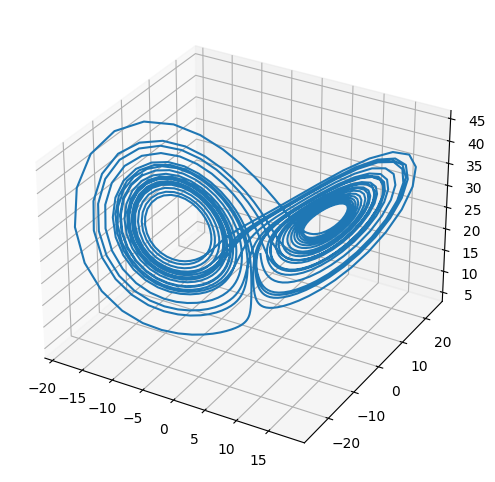

In [39]:
t, X = ode_integrate([1.0, 1.0, 20.0], 0.02, 30)
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot(X[0,:], X[1,:], X[2,:])
fig.set_size_inches(8.0,6.0)

### Multi-variate root find

We can find the steady points in this system by doing a multi-variate root find on the RHS vector

Note I start from three different initial guesses...

In [40]:
sol1 = optimize.root(f, [1., 1., 1.], jac=True)
print(sol1.x)

sol2 = optimize.root(f, [10., 10., 10.], jac=True)
print(sol2.x)

sol3 = optimize.root(f, [-10., -10., -10.], jac=True)
print(sol3.x)

[0. 0. 0.]
[ 8.48528137  8.48528137 27.        ]
[-8.48528137 -8.48528137 27.        ]


Text(0.5, 0, 'z')

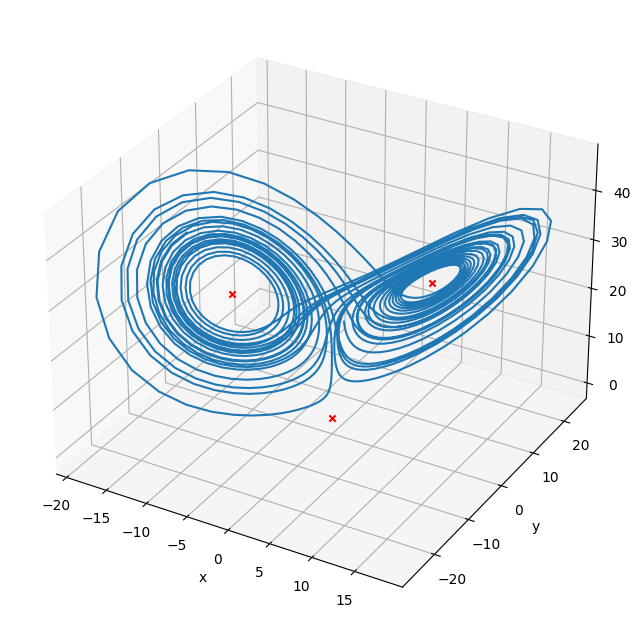

In [41]:
fig = plt.figure()
fig.set_size_inches(8, 8)
ax = plt.axes(projection='3d')

ax.plot(X[0,:], X[1,:], X[2,:])

ax.scatter(sol1.x[0], sol1.x[1], sol1.x[2], marker="x", color="r")
ax.scatter(sol2.x[0], sol2.x[1], sol2.x[2], marker="x", color="r")
ax.scatter(sol3.x[0], sol3.x[1], sol3.x[2], marker="x", color="r")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

### Stiff system of ODEs

A [stiff system of ODEs](https://en.wikipedia.org/wiki/Stiff_equation) is one where there are multiple disparate timescales for change and we need to respect all of them to get an accurate solution

Here is an example that comes up when studying the rates of chemical reactions (see, ex. Byrne & Hindmarsh 1986, or the VODE source code)

$$
\frac{d}{dt} \left (
   \begin{array}{c} y_1 \newline y_2 \newline y_3 \end{array}
  \right ) =
%
\left (
 \begin{array}{rrr}
  -0.04 y_1 & + 10^4 y_2 y_3  & \newline
   0.04 y_1 & - 10^4 y_2 y_3 & -3\times 10^7 y_2^2 \newline
   &  & 3\times 10^7 y_2^2 
\end{array}
\right )
$$

$$
{\bf J} = \left (
\begin{array}{ccc}
  -0.04 & 10^4 y_3 & 10^4 y_2 \newline
   0.04 & -10^4 y_3 - 6\times 10^7 y_2 & -10^4 y_2 \newline
   0 & 6\times 10^7 y_2 & 0 
\end{array}
\right )
$$

start with $y_1(0) = 1, y_2(0) = y_3(0) = 0$.  Long term behavior is $y_1, y_2 \rightarrow 0; y_3 \rightarrow 1$. Notice how we have terms that differ by several orders of magnitudes! A computer doesn't like it.

Using [LSODA](https://www.osti.gov/etdeweb/biblio/21352532) here, which is a powerful algorithm with automatic stiffness detection.

In [42]:
def rhs(t, Y):
    """ RHS of the system -- using 0-based indexing """
    y1 = Y[0]
    y2 = Y[1]
    y3 = Y[2]

    dy1dt = -0.04*y1 + 1.e4*y2*y3
    dy2dt =  0.04*y1 - 1.e4*y2*y3 - 3.e7*y2**2
    dy3dt =                         3.e7*y2**2

    return np.array([dy1dt, dy2dt, dy3dt])

def jac(t, Y):
    """ J_{i,j} = df_i/dy_j """

    y1 = Y[0]
    y2 = Y[1]
    y3 = Y[2]

    df1dy1 = -0.04
    df1dy2 = 1.e4*y3
    df1dy3 = 1.e4*y2

    df2dy1 = 0.04
    df2dy2 = -1.e4*y3 - 6.e7*y2
    df2dy3 = -1.e4*y2

    df3dy1 = 0.0
    df3dy2 = 6.e7*y2
    df3dy3 = 0.0

    return np.array([ [ df1dy1, df1dy2, df1dy3 ],
                      [ df2dy1, df2dy2, df2dy3 ],
                      [ df3dy1, df3dy2, df3dy3 ] ])

In [43]:
def vode_integrate(Y0, tmax):
    """ integrate using the NDF method """

    r = integrate.solve_ivp(rhs, (0.0, tmax), Y0,
                            method="LSODA", jac=jac, rtol=1.e-7, atol=1.e-10)

    # Note: this solver does not have a dens_output method, instead we 
    # access the solution data where it was evaluated internally via
    # the return object
    
    return r.t, r.y

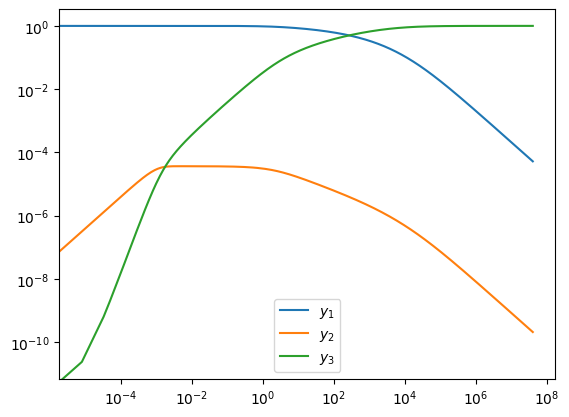

In [44]:
Y0 = np.array([1.0, 0.0, 0.0])
tmax = 4.e7

ts, Ys = vode_integrate(Y0, tmax)

ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')

plt.plot(ts, Ys[0,:], label=r"$y_1$")
plt.plot(ts, Ys[1,:], label=r"$y_2$")
plt.plot(ts, Ys[2,:], label=r"$y_3$")

plt.legend(loc="best");

## Boundary Value Problems

(From the [University of Chicago class](https://github.com/caam37830/book/blob/master/04_functions/bvp.ipynb))


In initial value problems, we find a unique solution to an ODE by specifying initial conditions.  Another way to obtain a unique solution to an ODE (or PDE) is to specify boundary values.


### The Heat Equation

The [Heat Equation](https://en.wikipedia.org/wiki/Heat_equation) is a second-order PDE obeying

\begin{equation}
\Delta u(x, t) = \partial_t u(x, t)
\end{equation}
where $\Delta$ is the Laplacian operator
\begin{equation}
\Delta = \sum_i \partial_i^2
\end{equation}

This equation is in a steady state if $\partial_t u = 0$ (i.e. the solution is not changing with time).  

We'll consider the steady state of the heat equation on a 1-dimensional domain $[0,1]$, where we have the ends of the domain set to fixed temperatures.  In this case, we can write the solution as a boundary value problem for a second-order ODE:
\begin{equation}
\frac{d^2 u}{dx^2} = 0 \qquad u\in (0,1)\\
u(0) = a\\
u(1) = b
\end{equation}

You might think of this as describing the temperature of a metal bar which is placed between two objects of differing temperatures. We know the temperatures at the beginning and at the end of the bar (and not the temperature and its derivative both at the beginning, as you would have for an IVP)

In [45]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp

We'll introduce the variable $p = du / dx$ to obtain a system of first-order ODEs:
\begin{equation}
\frac{dp}{dx} = 0\\
\frac{du}{dx} = p
\end{equation}

with the same boundary conditions.  The variable `y = [u, p]` will be a 2-vector containing the state.

We'll use boundary conditions $y(0)[0] = u(0) = 5 = a$ and $y(1)[0] = u(1) = 1 = b$

Finally, we use [`solve_bvp`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_bvp.html) from `scipy.integrate` to solve the boundary value problem. This implements a [collocation method](https://en.wikipedia.org/wiki/Collocation_method); another option is that of a [shooting method](https://en.wikipedia.org/wiki/Shooting_method).

My own experience on this mostly comes from this piece of work [Gerosa et al 2020](https://arxiv.org/abs/2004.02894) where the dynamics of gas disks around Kerr black holes gives rise to a very challenging boundary value problem. Collocation methods are amazing!   

In [46]:
# Note I'm using np.vstack here, very useful. For instance:
np.vstack((np.zeros(3), [3,4,5]))

array([[0., 0., 0.],
       [3., 4., 5.]])

In [47]:
a = 5
b = 1

def f(x, y):
    "right hand side of ODE"
    return np.vstack([y[1,:], np.zeros(y.shape[1])]) # du/dx = p, dp/dx = 0
    
def bc(y0, y1): # ya = y[:,0], yb = y[:,-1]
    "boundary condition residual"
    return np.array([y0[0] - a, y1[0] - b])

n = 100 # number of points
x = np.linspace(0,1,n)
# y0 = np.zeros((2,n))
y0 = np.random.randn(2,n)

# solve bvp
sol = solve_bvp(f, bc, x, y0)

We can plot the solution value

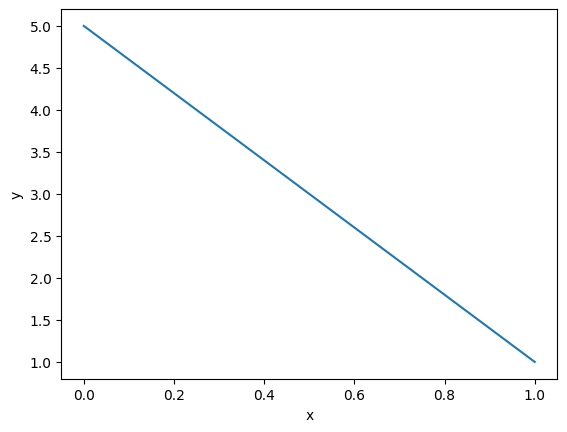

In [48]:
plt.plot(sol.x, sol.y[0,:])
plt.xlabel('x')
plt.ylabel('y')
plt.show()

We see the solution is a linear function from (0,5) to (1,1).  You can check that such a linear function solves the BVP mathematically.

We also provide a non-zero right hand side: $\partial_t u(x,t) = f(x)$.

/Users/dgerosa/box/lib/python3.11/site-packages/scipy/integrate/_bvp.py:1093: RuntimeWarning: invalid value encountered in divide
  r_middle = 1.5 * col_res / h
/Users/dgerosa/box/lib/python3.11/site-packages/scipy/integrate/_bvp.py:591: RuntimeWarning: invalid value encountered in divide
  slope = (y[:, 1:] - y[:, :-1]) / h


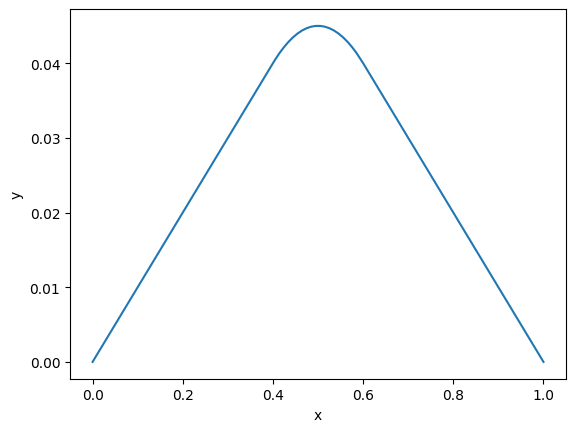

In [49]:
def f(x, y):
    "right hand side of ODE"
    src = -1*np.logical_and(x < 0.6, x > 0.4)
    return np.vstack([y[1,:], src])

def bc(ya, yb):
    "boundary condition residual"
    return np.array([ya[0], yb[0]])

n = 100 # number of points
x = np.linspace(0,1,n)
y0 = np.zeros((2,n))

# solve bvp
sol = solve_bvp(f, bc, x, y0)

plt.plot(sol.x, sol.y[0,:])
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Fitting

Fitting is used to match a model to experimental data.  E.g. we have N points of $(x_i, y_i)$ with associated errors, $\sigma_i$, and we want to find a simple function that best represents the data.

Usually, this means that we will need to define a metric, often called the residual (or loss function for the machine-learning people), for how well our function matches the data, and then minimize this residual.  Least-squares fitting is a popular formulation. The underlying assumption behind least-squares fitting is that errors are Gaussianly distributed which is often (but not always!) true because of the [Central Limit Theorem](https://en.wikipedia.org/wiki/Central_limit_theorem). In that case, one can prove least squares are equivalent to the maximum-likelihood estimator.  

We want to fit our data to a function $Y(x, \{a_j\})$, where $a_j$ are model parameters we can adjust.  We want to find the optimal $a_j$ to minimize the distance of $Y$ from our data:

$$\Delta_i = Y(x_i, \{a_j\}) - y_i$$

Least-squares minimizes $\chi^2$:

$$\chi^2(\{a_j\}) = \sum_{i=1}^N \left ( \frac{\Delta_i}{\sigma_i} \right )^2$$


**Careful** For your own research, always make sure you *can* actually use least-square fitting! This requires errors to be normally distributed.  Often it's not the case and this technique is widely abused.  

### General linear least squares

First we'll make some experimental data (a quadratic with random fashion).  We use the randn() function to provide Gaussian normalized errors.

In [50]:
def y_experiment2(a1, a2, a3, sigma, x):
    """ return the experimental data in a quadratic + random fashion,                              
        with a1, a2, a3 the coefficients of the quadratic and sigma is                             
        the error.  This will be poorly matched to a linear fit for                                
        a3 != 0 """

    N = len(x)

    # randn gives samples from the "standard normal" distribution                                  
    r = np.random.randn(N)

    y = a1 + a2*x + a3*x*x + sigma*r

    return y

N = 40
sigma = 5.0*np.ones(N)

x = np.linspace(0, 100.0, N)
y = y_experiment2(2.0, 1.50, -0.02, sigma, x)

<ErrorbarContainer object of 3 artists>

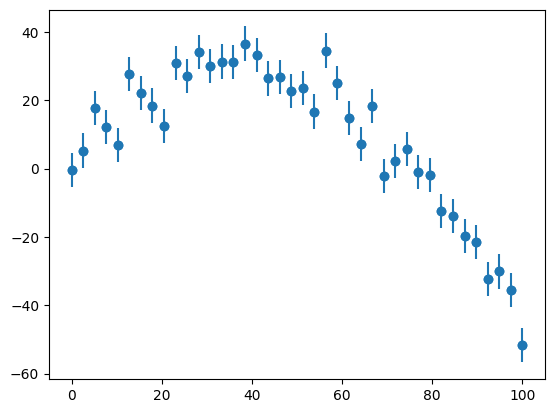

In [51]:
fig, ax = plt.subplots()
ax.scatter(x,y)
ax.errorbar(x, y, yerr=sigma, fmt="o")

In [52]:
def resid(avec, x, y, sigma):
    """ the residual function -- this is what will be minimized by the
        scipy.optimize.leastsq() routine.  avec is the parameters we
        are optimizing -- they are packed in here, so we unpack to
        begin.  (x, y) are the data points 

        scipy.optimize.leastsq() minimizes:

           x = arg min(sum(func(y)**2,axis=0))
                    y

        so this should just be the distance from a point to the curve,
        and it will square it and sum over the points
        """

    a0, a1, a2 = avec
    
    return (y - (a0 + a1*x + a2*x**2))/sigma

In [53]:
# initial guesses
a0, a1, a2 = 1, 1, 1

afit, flag = optimize.leastsq(resid, [a0, a1, a2], args=(x, y, sigma))

print(afit)

[ 3.3484941   1.42484907 -0.01928932]


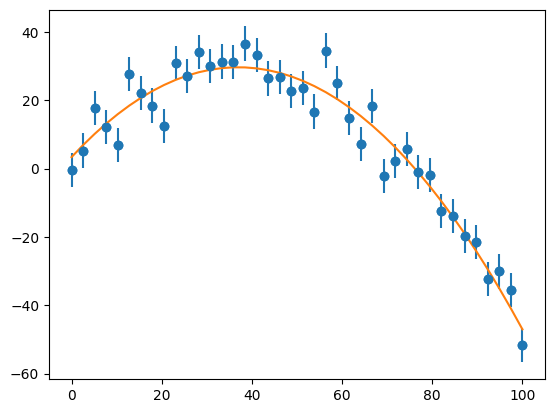

In [54]:
ax.plot(x, afit[0] + afit[1]*x + afit[2]*x*x )
fig

$\chi^2$

In [55]:
chisq = sum(np.power(resid(afit, x, y, sigma),2))
normalization = len(x)-len(afit)
print(chisq/normalization)

1.270912673692861


### A nonlinear example

Our experimental data are an exponential now

In [56]:
a0 = 2.5
a1 = 2./3.
sigma = 5.0

a0_orig, a1_orig = a0, a1

x = np.linspace(0.0, 4.0, 25)
y = a0*np.exp(a1*x) + sigma*np.random.randn(len(x))

<ErrorbarContainer object of 3 artists>

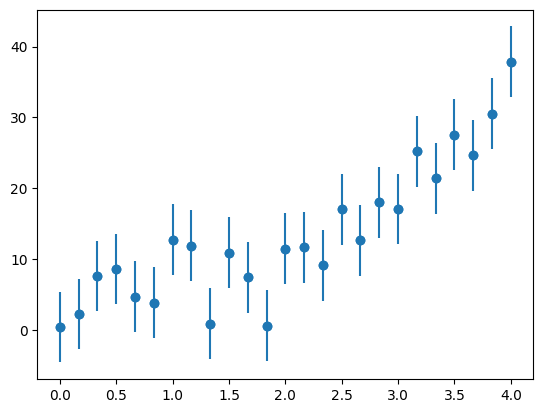

In [57]:
fig, ax = plt.subplots()
ax.scatter(x,y)
ax.errorbar(x, y, yerr=sigma, fmt="o", label="_nolegend_")

Our function to minimize

In [58]:
def resid(avec, x, y):
    """ the residual function -- this is what will be minimized by the                             
        scipy.optimize.leastsq() routine.  avec is the parameters we                               
        are optimizing -- they are packed in here, so we unpack to                                 
        begin.  (x, y) are the data points                                                         
                                                                                                   
        scipy.optimize.leastsq() minimizes:                                                        
                                                                                                   
           x = arg min(sum(func(y)**2,axis=0))                                                     
                    y                                                                              
                                                                                                   
        so this should just be the distance from a point to the curve,                             
        and it will square it and sum over the points                                              
        """

    a0, a1 = avec

    # note: if we wanted to deal with error bars, we would weight each                             
    # residual accordingly                                                                         
    return y - a0*np.exp(a1*x)

In [59]:
a0, a1 = 1, 1
afit, flag = optimize.leastsq(resid, [a0, a1], args=(x, y))

print(flag)
print(afit)

1
[3.08523862 0.60549636]


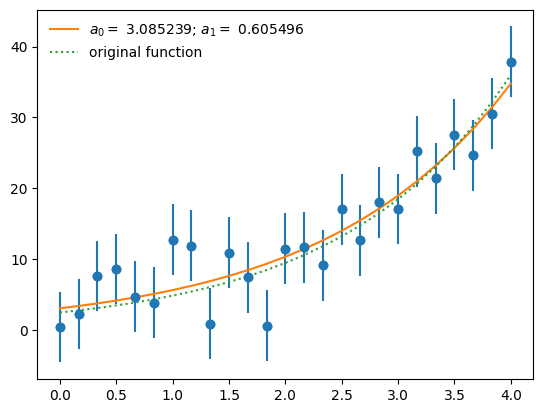

In [60]:
ax.plot(x, afit[0]*np.exp(afit[1]*x),
           label=r"$a_0 = $ %f; $a_1 = $ %f" % (afit[0], afit[1]))
ax.plot(x, a0_orig*np.exp(a1_orig*x), ":", label="original function")
ax.legend(numpoints=1, frameon=False)
fig

## Fourier Transforms

Fourier transforms convert a physical-space (or time series) representation of a function into frequency space.  This provides an equivalent representation of the data with a new view.

The [FFT](https://en.wikipedia.org/wiki/Fast_Fourier_transform#:~:text=A%20fast%20Fourier%20transform%20(FFT,frequency%20domain%20and%20vice%20versa.) and its inverse in numpy use:

$$F_k = \sum_{n=0}^{N-1} f_n e^{-2\pi i nk/N}$$

$$f_n = \frac{1}{N} \sum_{k=0}^{N-1} F_k 
   e^{2\pi i n k/N}$$
   

Both numpy and scipy have FFT routines that are similar.  However, the numpy version returns the data in a more convenient form.

It's always best to start with something you understand -- let's do a simple sine wave.  Since our function is real, we can use the rfft routines in NumPy -- they understand that we are working with real data and they don't return the negative frequency components.

One important caveat -- FFTs assume that you are periodic.  If you include both endpoints of the domain in the points that comprise your sample then you will not match this assumption.  Here we use endpoint=False with linspace()

In [86]:
def single_freq_sine(npts):

    # a pure sine with no phase shift will result in pure imaginary                                         
    # signal                                                                                                
    f_0 = 0.2

    xmax = 10.0/f_0
    
    xx = np.linspace(0.0, xmax, npts, endpoint=False)

    f = np.sin(2.0*np.pi*f_0*xx)

    return xx, f

To make our life easier, we'll define a function that plots all the stages of the FFT process

In [62]:
def plot_FFT(xx, f):

    npts = len(xx)

    # Forward transform: f(x) -> F(k)                                                                       
    fk = np.fft.rfft(f)

    # Normalization -- the '2' here comes from the fact that we are                                         
    # neglecting the negative portion of the frequency space, since                                         
    # the FFT of a real function contains redundant information, so                                         
    # we are only dealing with 1/2 of the frequency space.                                                  
    #                                                                                                       
    # technically, we should only scale the 0 bin by N, since k=0 is                                        
    # not duplicated -- we won't worry about that for these plots                                           
    norm = 2.0/npts

    fk = fk*norm

    fk_r = fk.real
    fk_i = fk.imag

    # the fftfreq returns the positive and negative (and 0) frequencies                                      
    # the newer versions of numpy (>=1.8) have an rfftfreq() function                                       
    # that really does what we want -- we'll use that here.                                                 
    k = np.fft.rfftfreq(npts)

    # to make these dimensional, we need to divide by dx.  Note that                                        
    # max(xx) is not the true length, since we didn't have a point                                          
    # at the endpoint of the domain.                                                                        
    kfreq = k*npts/(max(xx) + xx[1])

    # Inverse transform: F(k) -> f(x) -- without the normalization                                          
    fkinv = np.fft.irfft(fk/norm)

    # plots
    fig, ax = plt.subplots(nrows=4, ncols=1)
    
    ax[0].plot(xx, f)
    ax[0].set_xlabel("x")
    ax[0].set_ylabel("f(x)")

    ax[1].plot(kfreq, fk_r, label=r"Re($\mathcal{F}$)")
    ax[1].plot(kfreq, fk_i, ls=":", label=r"Im($\mathcal{F}$)")
    ax[1].set_xlabel(r"$\nu_k$")
    ax[1].set_ylabel("F(k)")

    ax[1].legend(fontsize="small", frameon=False)

    ax[2].plot(kfreq, np.abs(fk))
    ax[2].set_xlabel(r"$\nu_k$")
    ax[2].set_ylabel(r"|F(k)|")

    ax[3].plot(xx, fkinv.real)
    ax[3].set_xlabel(r"$\nu_k$")
    ax[3].set_ylabel(r"inverse F(k)")

    f = plt.gcf()
    
    f.set_size_inches(10,8)
    plt.tight_layout()


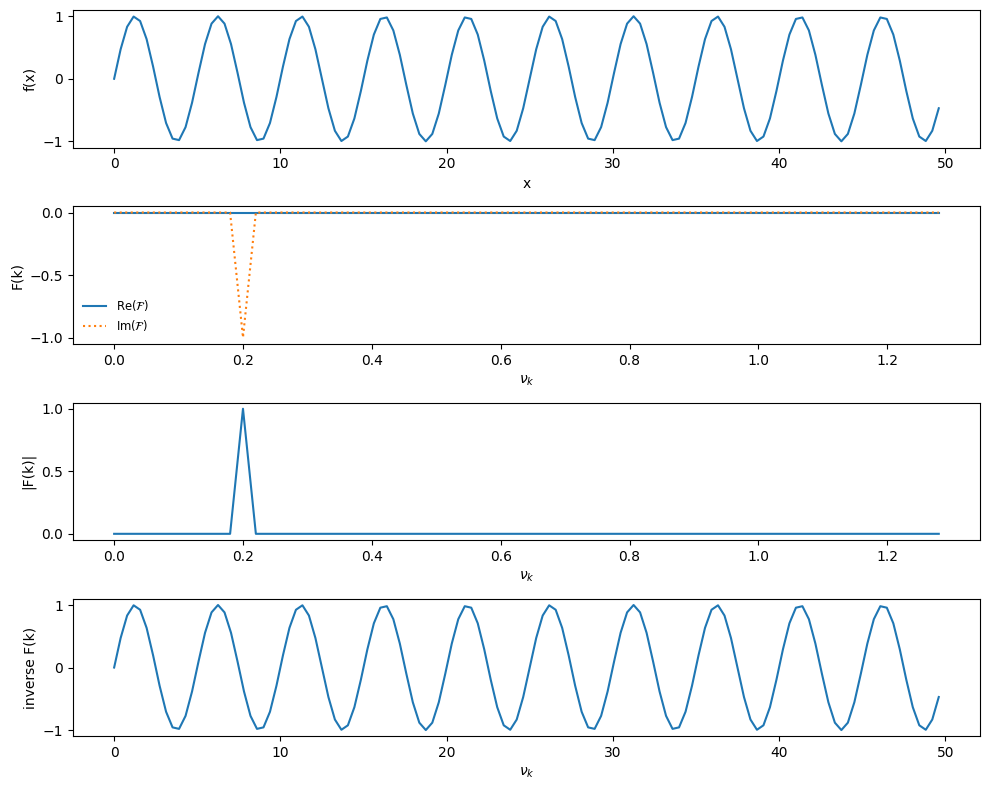

In [63]:
npts = 128
xx, f = single_freq_sine(npts)
plot_FFT(xx, f)

A cosine is shifted in phase by pi/2

In [64]:
def single_freq_cosine(npts):

    # a pure cosine with no phase shift will result in pure real                                            
    # signal                                                                                                
    f_0 = 0.2

    xmax = 10.0/f_0

    xx = np.linspace(0.0, xmax, npts, endpoint=False)

    f = np.cos(2.0*np.pi*f_0*xx)

    return xx, f

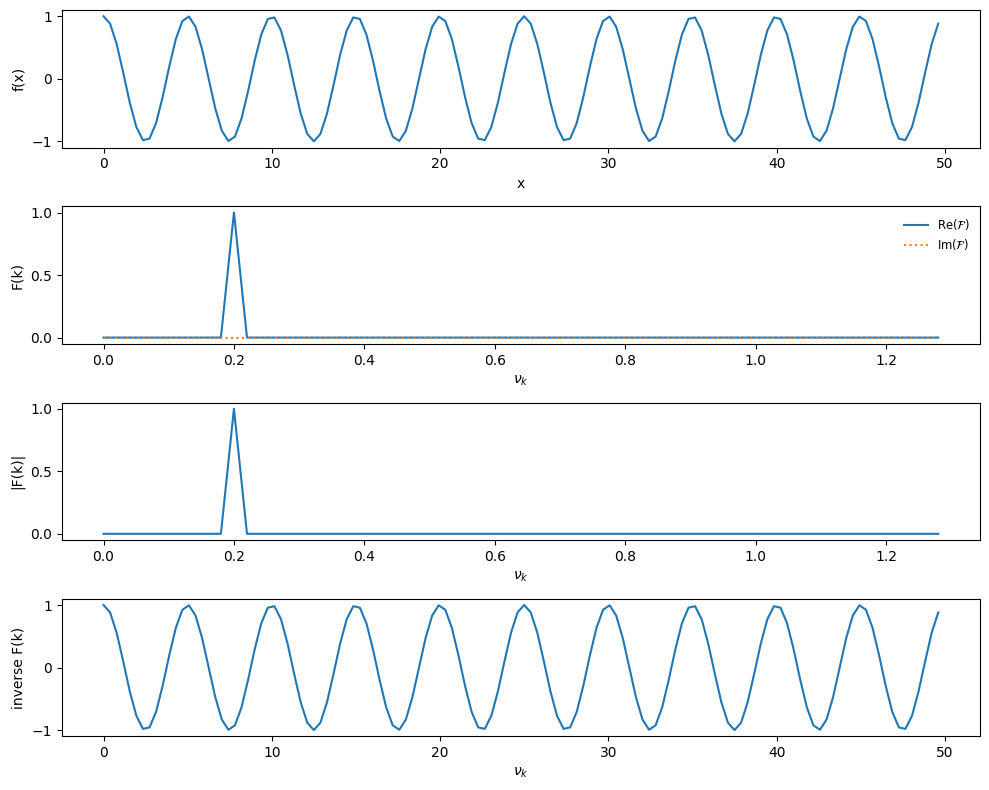

In [65]:
xx, f = single_freq_cosine(npts)
plot_FFT(xx, f)

Now let's look at a sine with a pi/4 phase shift

In [66]:
def single_freq_sine_plus_shift(npts):

    # a pure sine with no phase shift will result in pure imaginary                                         
    # signal                                                                                                
    f_0 = 0.2

    xmax = 10.0/f_0

    xx = np.linspace(0.0, xmax, npts, endpoint=False)

    f = np.sin(2.0*np.pi*f_0*xx + np.pi/4)

    return xx, f

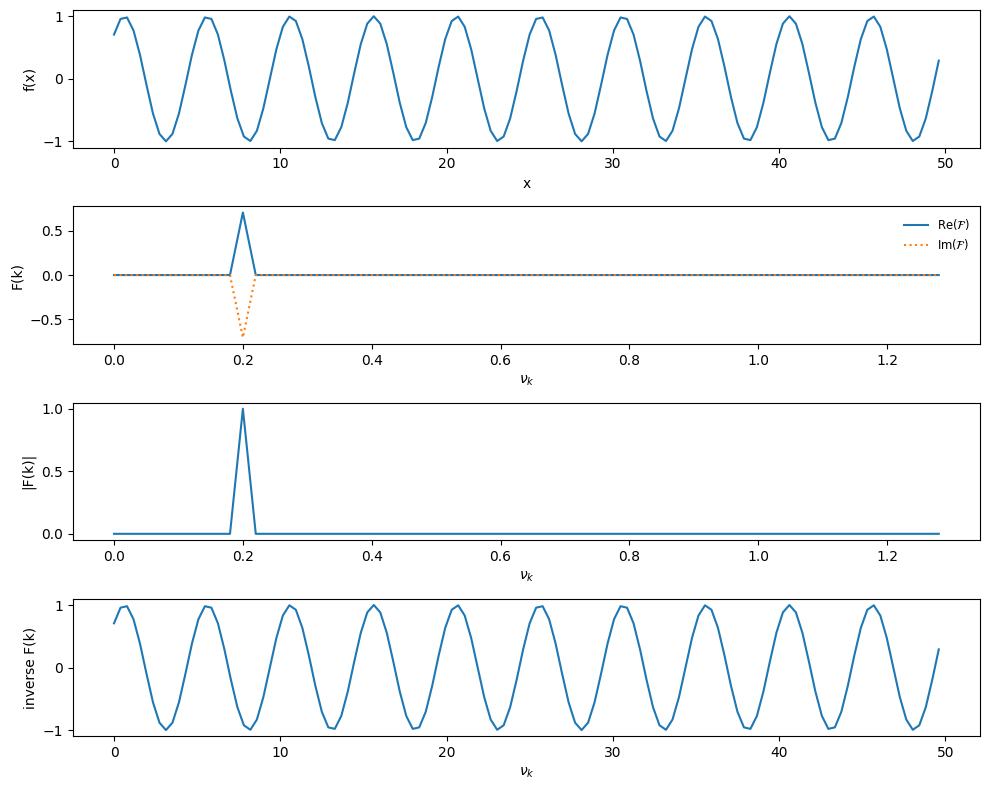

In [67]:
xx, f = single_freq_sine_plus_shift(npts)
plot_FFT(xx, f)

### A frequency filter

We'll setup a simple two-frequency sine wave and filter a component

In [68]:
def two_freq_sine(npts):

    # a pure sine with no phase shift will result in pure imaginary             
    # signal                                                                    
    f_0 = 0.2
    f_1 = 0.5

    xmax = 10.0/f_0

    # we call with endpoint=False -- if we include the endpoint, then for       
    # a periodic function, the first and last point are identical -- this       
    # shows up as a signal in the FFT.                                          
    xx = np.linspace(0.0, xmax, npts, endpoint=False)

    f = 0.5*(np.sin(2.0*np.pi*f_0*xx) + np.sin(2.0*np.pi*f_1*xx))

    return xx, f

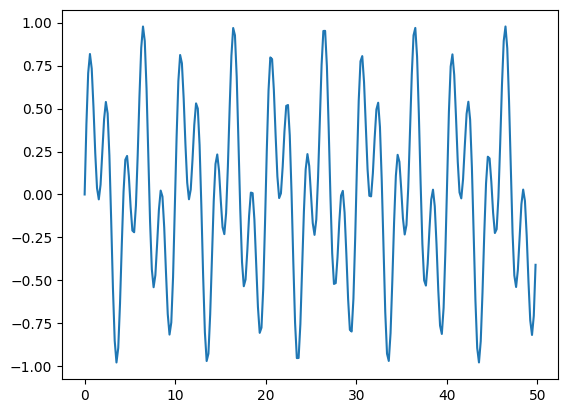

In [69]:
npts = 256

xx, f = two_freq_sine(npts)

fig, ax = plt.subplots()
ax.plot(xx, f)

we'll take the transform: f(x) -> F(k)

In [70]:
# normalization factor: the 2 here comes from the fact that we neglect          
# the negative portion of frequency space because our input function            
# is real                                                                       
norm = 2.0/npts
fk = norm*np.fft.rfft(f)

ofk_r = fk.real.copy()
ofk_i = fk.imag.copy()

# get the frequencies
k = np.fft.rfftfreq(len(xx))

# since we don't include the endpoint in xx, to normalize things, we need       
# max(xx) + dx to get the true length of the domain
#
# This makes the frequencies essentially multiples of 1/dx
kfreq = k*npts/(max(xx) + xx[1])

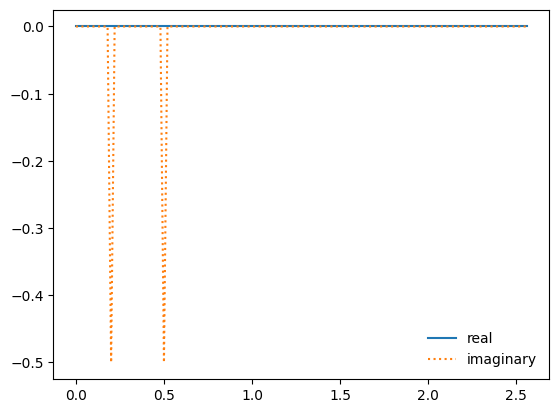

In [71]:
fig, ax = plt.subplots()
ax.plot(kfreq, fk.real, label="real")
ax.plot(kfreq, fk.imag, ":", label="imaginary")
ax.legend(frameon=False)

Filter out the higher frequencies

In [72]:
fk[kfreq > 0.4] = 0.0

# element 0 of fk is the DC component                                           
fk_r = fk.real
fk_i = fk.imag

# Inverse transform: F(k) -> f(x)                                               
fkinv = np.fft.irfft(fk/norm)

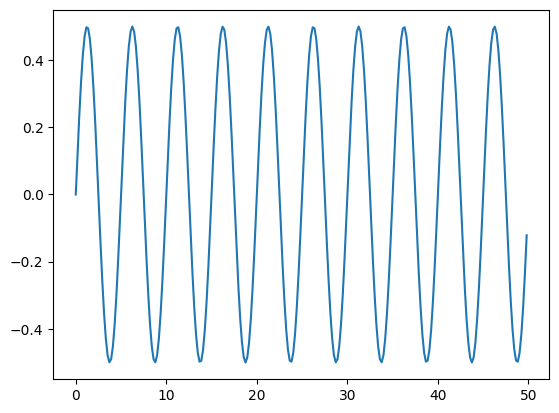

In [73]:
fig, ax = plt.subplots()
ax.plot(xx, fkinv.real)

## Linear Algebra

### General manipulations of matrices

You can use regular numpy arrays or you can use a special matrix class that offers some shortcuts

In [74]:
a = np.array([[1.0, 2.0], [3.0, 4.0]])

In [75]:
print(a)
print(a.transpose())
print(a.T)

[[1. 2.]
 [3. 4.]]
[[1. 3.]
 [2. 4.]]
[[1. 3.]
 [2. 4.]]


In [76]:
ainv = np.linalg.inv(a)
print(ainv)

[[-2.   1. ]
 [ 1.5 -0.5]]


In [77]:
a @ ainv

array([[1.0000000e+00, 0.0000000e+00],
       [8.8817842e-16, 1.0000000e+00]])

The eye() function will generate an identity matrix (as will the identity())

In [78]:
print(np.eye(2))
print(np.identity(2))

[[1. 0.]
 [0. 1.]]
[[1. 0.]
 [0. 1.]]


We can solve Ax = b

In [79]:
b = np.array([5, 7])
x = np.linalg.solve(a, b)
print(x)

[-3.  4.]


### The matrix class

In [80]:
A = np.matrix('1.0 2.0; 3.0 4.0')
print(A)
print(A.T)

[[1. 2.]
 [3. 4.]]
[[1. 3.]
 [2. 4.]]


In [81]:
X = np.matrix('5.0 7.0')
Y = X.T

print(A*Y)

[[19.]
 [43.]]


In [82]:
print(A.I*Y)

[[-3.]
 [ 4.]]


### Tridiagonal matrix solve

Here we'll solve the equation:

$$f^{\prime\prime} = g(x)$$

with $g(x) = \sin(x)$, and the domain $x \in [0, 2\pi]$, with boundary conditions $f(0) = f(2\pi) = 0$.  The solution is simply $f(x) = -\sin(x)$.

We'll use a grid of $N$ points with $x_0$ on the left boundary and $x_{N-1}$ on the right boundary.

We difference our equation as:

$$f_{i+1} - 2 f_i + f_{i-1} = \Delta x^2 g_i$$

We keep the boundary points fixed, so we only need to solve for the $N-2$ interior points.  Near the boundaries, our difference is:

$$f_2 - 2 f_1 = \Delta x^2 g_1$$

and

$$-2f_{N-1} + f_{N-2} = \Delta x^2 g_{N-1}$$

We can write the system of equations for solving for the $N-2$ interior points as:

$$A = \left (
\begin{array}{ccccccc}
-2 &  1 &    &        &         &           &          \newline
1  & -2 &  1 &        &         &           &          \newline
   &  1 & -2 & 1      &         &           &          \newline
   &         & \ddots & \ddots & \ddots  &           &          \newline
   &         &        & \ddots & \ddots  & \ddots  &          \newline
   &         &        &        & 1       & -2 & 1  \newline
   &         &        &        &         & 1  & -2 \newline
\end{array}
\right )
$$

$$
x = \left (
\begin{array}{c}
f_\mathrm{1} \\\
f_\mathrm{2} \\\
f_\mathrm{3} \\\
\vdots \\\
\vdots \\\
f_\mathrm{N-2} \\\
f_\mathrm{N-1} \\\
\end{array}
\right )
$$

$$
b = \Delta x^2 \left (
\begin{array}{c}
g_\mathrm{1} \\\
g_\mathrm{2} \\\
g_\mathrm{3} \\\
\vdots \\\
\vdots \\\
g_\mathrm{N-2} \\\
g_\mathrm{N-1}\\\
\end{array}
\right )
$$

Then we just solve $A x = b$

In [83]:
import scipy.linalg as linalg

# our grid -- including endpoints
N = 100
x = np.linspace(0.0, 2.0*np.pi, N, endpoint=True)
dx = x[1]-x[0]

# our source
g = np.sin(x)

# our matrix will be tridiagonal, with [1, -2, 1] on the diagonals
# we only solve for the N-2 interior points

# diagonal
d = -2*np.ones(N-2)

# upper -- note that the upper diagonal has 1 less element than the
# main diagonal.  The SciPy banded solver wants the matrix in the 
# form:
#
# *    a01  a12  a23  a34  a45    <- upper diagonal
# a00  a11  a22  a33  a44  a55    <- diagonal
# a10  a21  a32  a43  a54   *     <- lower diagonal
#

u = np.ones(N-2)
u[0] = 0.0

# lower
l = np.ones(N-2)
l[N-3] = 0.0

# put the upper, diagonal, and lower parts together as a banded matrix
A = np.matrix([u,d,l])

# solve A sol = dx**2 g for the inner N-2 points
sol = linalg.solve_banded((1,1), A, dx**2*g[1:N-1])

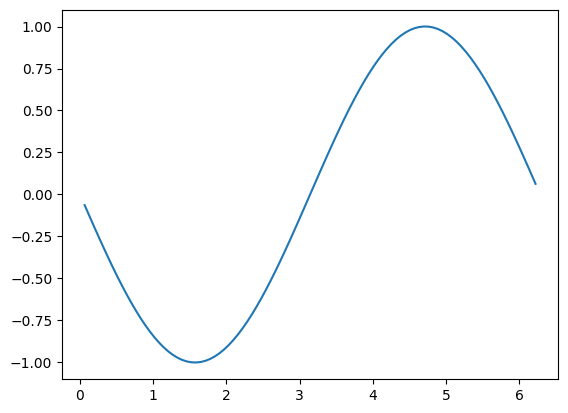

In [84]:
fig, ax = plt.subplots()
ax.plot(x[1:N-1], sol)

In [85]:
import numpy as np
import matplotlib.pyplot as plt

# Exercises

For the exam, please complete two of these exercise (don't pick both Q1 and Q2, too easy)

## Q1: Simple numerical integral

Numerical integration methods work differently depending on whether you have the analytic function available (in which case you can evaluate it freely at any point you please) or if it is sampled for you.

Consider the function $f(x) = e^{-x^2}$.  We want to integrate this from $[-5, 5]$.  The
analytic integral is not easily obtained.  Use `integrate.quad` to do the integration.

Consider now that you have data that represents a function sampled a `N` points, but you don't know the analytic form of the function.  Here, we create the sampling from a uniform distribution

In [95]:
N = 32
x = np.linspace(-5, 5, N)
f = np.exp(-x**2)
f

array([1.38879439e-11, 3.15061953e-10, 5.80457065e-09, 8.68481106e-08,
       1.05527775e-06, 1.04133225e-05, 8.34503173e-05, 5.43103745e-04,
       2.87047478e-03, 1.23208538e-02, 4.29481052e-02, 1.21580337e-01,
       2.79510942e-01, 5.21855680e-01, 7.91258065e-01, 9.74320895e-01,
       9.74320895e-01, 7.91258065e-01, 5.21855680e-01, 2.79510942e-01,
       1.21580337e-01, 4.29481052e-02, 1.23208538e-02, 2.87047478e-03,
       5.43103745e-04, 8.34503173e-05, 1.04133225e-05, 1.05527775e-06,
       8.68481106e-08, 5.80457065e-09, 3.15061953e-10, 1.38879439e-11])

Compute the integral of this sampled function using Simpson's method (`integrate.simps`).  Now, vary the number of sample points (try 64, 128, ...) and see how the answer changes.  Simpson's method is 4-th order accurate, which means that the error should decrease by $2^4$ when we double the number of sample points.

Make a plot of the error (compared to the quadrature result) vs. N

## Q2: Interpolation error

There are a large number of different interpolation schemes available through scipy.  Let's test them out.

Create a python function, $f(x)$, that is your true function (make it complicated!).  Now create $N$ samples of it (either regularly spaced or irregularly spaced).

Try some of the different interpolation routines.  `interpolate.interp1d` takes a `kind` argument that lets you choose the order of the interpolation.  Measure the error in the method, by comparing the interpolated result with the actual function value.  

Then do the same cubic splines (look at `CubicSpline`)

Plot the resulting interpolant.

## Q3: Basins of attraction

Consider the function

$$q(x) = x^3 - 2x^2 - 11x + 12$$

This has 3 roots has you should find them all. This equation is known to cause problems for some root-finding methods because it exhibits [basis of attraction](https://en.wikipedia.org/wiki/Newton%27s_method#Basins_of_attraction) -- very closely spaced initial guesses leave to very different roots.

Find all three roots using both `optimize.brentq` and `optimize.root`.

In [96]:
from scipy import optimize

## Q5: Planetary orbits

We want to consider planetary orbits.  To do this, we need to solve Newton's second law together with Newton's law of gravity.  If we restrict ourselves to the x-y plane, then there are 4 quantities we need to solve for: $x$, $y$, $v_x$, and $v_y$.  These evolve according to:

\begin{align*}
\frac{dx}{dt} &= v_x \\
\frac{dy}{dt} &= v_y \\
\frac{dv_x}{dt} &= a_x = -\frac{GM_\star x}{r^3} \\
\frac{dv_y}{dt} &= a_y = -\frac{GM_\star y}{r^3}
\end{align*}

To integrate these forward in time, we need an initial condition for each quantity.  We'll setup our system such that the Sun is at the origin (that will be one focus), and the planet begins at perihelion and orbits counterclockwise. 

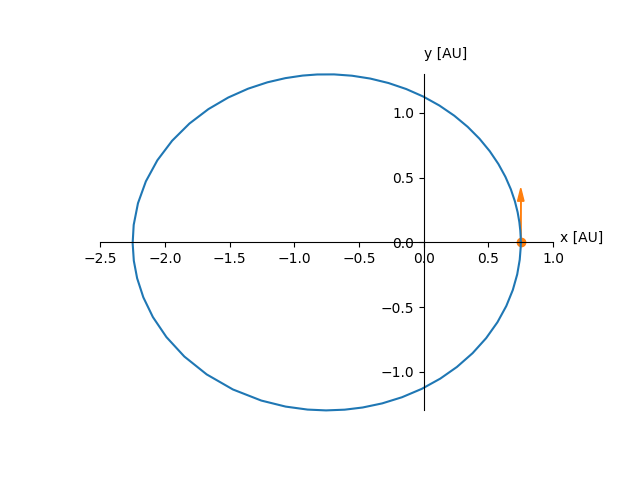

The distance of perihelion from the focus is:

$$r_p = a (1 - e)$$

where $a$ is the semi-major axis and $e$ is the eccentricity.  The perihelion velocity is all in the $y$ direction and is:

$$v_y = v_p = \sqrt{\frac{GM_\star}{a} \frac{1+e}{1-e}}$$

We'll work in units of AU, years, and solar masses, in which case, $GM_\star = 4\pi^2$ (for the Sun).  

Your initial conditions should be:

  * $x(t=0) = r_p$
  * $y(t=0) = 0$
  * $v_x(t=0) = 0$
  * $v_y(t=0) = v_p$

Use the scipy ODE integration methods to integrate an orbit and plot it

## Q6: Damped driven pendulum and chaos

There are a large class of ODE integration methods available through the `scipy.integrate.ode()` function.  Not all of them provide _dense output_ -- most will just give you the value at the end of the integration.  

The explicit Runge-Kutta integrator will give you access to the solution at intermediate points and provides methods to interpolate to any value.  You enable this via `dense_output=True`.

The damped-driven pendulum obeys the following equations:

$$\dot{\theta} = \omega$$

$$\dot{\omega} = -q \omega - \sin \theta + b \cos \omega_d t$$

here, $\theta$ is the angle of the pendulum from vertical and $\omega$ is the angular velocity.  $q$ is a damping coefficient, $b$ is a forcing amplitude, and $\omega_d$ is a driving frequency.

Choose $q = 0.5$ and $\omega_d = 2/3$.

Integrate the system for different values of $b$ (start with $b = 0.9$ and increase by $0.05$, and plot the results ($\theta$ vs. $t$).  Here's a RHS function to get you started:

In [98]:
def rhs(t, Y, q, omega_d, b):
        """ damped driven pendulum system derivatives.  Here, Y = (theta, omega) are
        the solution variables. """
        f = np.zeros_like(Y)
        
        f[0] = Y[1]
        f[1] = -q*Y[1] - np.sin(Y[0]) + b*np.cos(omega_d*t)

        return f

Note that the pendulum can flip over, giving values of $\theta$ outside of $[-\pi, \pi]$.  The following function can be used to restrict it back to $[-\pi, \pi]$ for plotting.

In [99]:
def restrict_theta(theta):
    """ convert theta to be restricted to lie between -pi and pi"""
    tnew = theta + np.pi
    tnew += -2.0*np.pi*np.floor(tnew/(2.0*np.pi))
    tnew -= np.pi
    return tnew

Write a function that takes an initial angle, $\theta_0$, and integrates the system and returns the solution.

Note, the righthand side function, `rhs`, takes additional arguments that you need to pass through the integrator.  The preferred method to do this with the `solve_ivp()` interface appears to be to use `functools.partial()`, as:
```
from functools import partial

r = solve_ivp(partial(rhs, q=q, omega_d=omega_d, b=b), ...)
```

Some values of $b$ will show very non-periodic behavior.  To see chaos, integrate two different pendula that are the same except for $\theta_0$, with only a small difference between then (like 60 degrees and 60.0001 degrees.  You'll see the solutions track for a while, but then diverge.

## Q6: Condition number

For a linear system, ${\bf A x} = {\bf b}$, we can only solve for $x$ if the determinant of the matrix ${\bf A}$ is non-zero.  If the determinant is zero, then we call the matrix _singular_.  The _condition number_ of a matrix is a measure of how close we are to being singular.  The formal definition is:

\begin{equation}
\mathrm{cond}({\bf A}) = \| {\bf A}\| \| {\bf A}^{-1} \|
\end{equation}

But we can think of it as a measure of how much ${\bf x}$ would change due to a small change in ${\bf b}$.  A large condition number means that our solution for ${\bf x}$ could be inaccurate.

A _Hilbert matrix_ has $H_{ij} = (i + j + 1)^{-1}$, and is known to have a large condition number.  Here's a routine to generate a Hilbert matrix (with a `for` loop, I'm a terrible programmer!) 

In [100]:
def hilbert(n):
    """ return a Hilbert matrix, H_ij = (i + j - 1)^{-1} """

    H = np.zeros((n,n), dtype=np.float64)

    for i in range(1, n+1):
        for j in range(1, n+1):
            H[i-1,j-1] = 1.0/(i + j - 1.0)
    return H

Let's solve ${\bf Hx} ={\bf b}$.  Create a linear system by picking an ${\bf x}$ and generating a ${\bf b}$ by multiplying by the matrix ${\bf H}$.  Then use the `scipy.linalg.solve()` function to recover ${\bf x}$.  Compute the error in ${\bf x}$ as a function of the size of the matrix.

You won't need a large matrix, $n \sim 13$ or so, will start showing big errors.

You can compute the condition number with `numpy.linalg.cond()`

There are methods that can do a better job with nearly-singular matrices.  Take a look at `scipy.linalg.lstsq()` for example.

## Q7: Noisy signal

A convolution is defined as:  

\begin{equation}  
  (f \star g)(t) \equiv \int_{-\infty}^{\infty} f(\tau) g(t - \tau) d\tau \tag{1}  
\end{equation}  

It is easy to compute this with FFTs, via the _convolution theorem_,  

\begin{equation}  
  \mathcal{F}\{f \star g\} = \mathcal{F}\{f\} \, \mathcal{F}\{g\} \tag{2}  
\end{equation}  

That is: the Fourier transform of the convolution of $f$ and $g$ is simply the product of the individual transforms of $f$ and $g$. This allows us to compute the convolution via multiplication in Fourier space and then take the inverse transform, $\mathcal{F}^{-1}\{\}$, to recover the convolution in real space:

\begin{equation}  
  f \star g = \mathcal{F}^{-1}\{ \mathcal{F}\{f\} \, \mathcal{F}\{g\}\} \tag{3}  
\end{equation}  

A common use of a convolution is to smooth noisy data, for example by convolving noisy data with a Gaussian. We'll do that here.


Here's some noisy data we'll work with

In [91]:
def fdata(x, L):
    A = L/10.0
    return 2*np.sin(2*np.pi*x/L) + x*(L-x)**2/L**3 * np.cos(x) + \
           5*x*(L-x)/L**2 + A/2 + 0.1*A*np.sin(13*np.pi*x/L)

N = 2048
L = 50.0
x = np.linspace(0, L, N, endpoint=False)
orig = fdata(x, L)
noisy = orig + 0.5*np.random.randn(N)

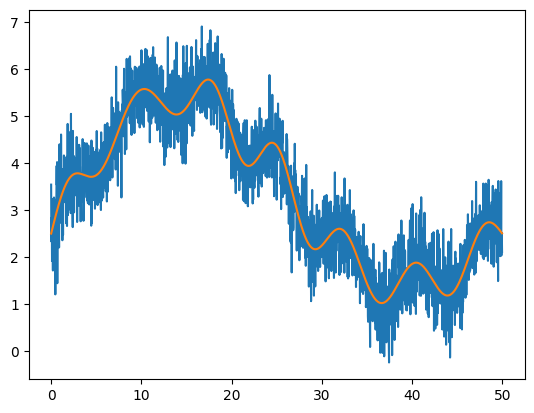

In [92]:
plt.plot(x, noisy)
plt.plot(x, orig)

SciPy provides a convolution function `scipy.signal.convolve()` that can do the convolution for us directly.  To smooth the data, we want to use a Gaussian, which can be produced by `scipy.signal.gaussian()`.

Convolve the noisy data with a Gaussian and plot the result together with the original data `orig`.  You'll need to play with the width of the Gaussian to get a nice smoothing.  You also will need to normalize the Gaussian so that it sums to 1, otherwise, your convolved data will be shifted verfically from the original function.

## Q8: FFT of the chaotic pendulum

In Q6 we looked at ODEs and the chaotic pendulum, and were interested in writing a method to integrate the pendulum in time.

Here we want to examine its behavior in frequency space.  The code below will integrate the chaotic pendulum, while requesting that the solution be stored at points spaced with a fixed dt, which makes it suitable for taking the FFT.

In [87]:
from functools import partial
from scipy.integrate import solve_ivp

def rhs(t, Y, q, omega_d, b):
    """ damped driven pendulum system derivatives.  Here, Y = (theta, omega) are
        the solution variables. """
    f = np.zeros_like(Y)
        
    f[0] = Y[1]
    f[1] = -q*Y[1] - np.sin(Y[0]) + b*np.cos(omega_d*t)

    return f

def restrict_theta(theta):
    """ convert theta to be restricted to lie between -pi and pi"""
    tnew = theta + np.pi
    tnew += -2.0*np.pi*np.floor(tnew/(2.0*np.pi))
    tnew -= np.pi
    return tnew

def int_pendulum(theta0, q, omega_d, b, tend, dt):
    """ integrate the pendulum and return solution with dt"""

    # points in time where we'll request the solution
    tpoints = np.arange(0.0, tend, dt)
    
    r = solve_ivp(partial(rhs, q=q, omega_d=omega_d, b=b),
                  [0.0, tend], [theta0, 0.0],
                  method='RK45', t_eval=tpoints)

    return r.t, r.y

The call below will give an undamped pendulum.  For a small amplitude, since we have $L = g$ in our pendulum, the period is simply $T = 2\pi$, and the frequency is $\nu_k = 1/(2\pi)$.  We plot things in terms of angular frequency, $\omega_k = 2\pi \nu_k$, so all the power will be at $\omega_k = 1$.

In [88]:
t, y = int_pendulum(np.radians(10), 0.0, 0.6666, 0.0, 200.0, 0.1)

Your task is to complete the power spectrum routine below to calculate the FFT of theta and plot it.  Experiment with the damping and driving parameters to see the complexity of the pendulum in frequency space when it becomes chaotic.  For reference, here's a plot of the solution theta

Text(0, 0.5, '$\\theta$')

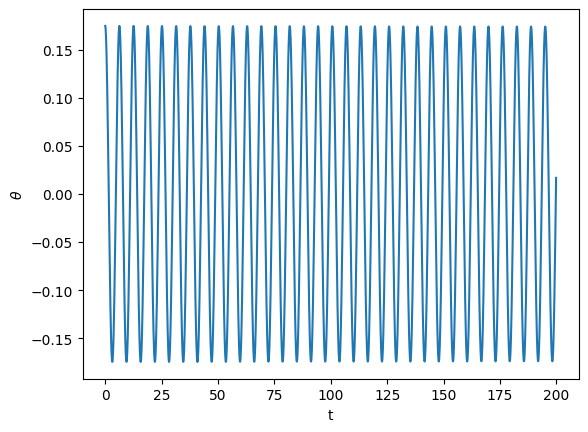

In [89]:
plt.plot(t, restrict_theta(y[0,:]))
plt.xlabel("t")
plt.ylabel(r"$\theta$")

In [90]:
def power_spectrum(t, theta0):
    """ return the power spectrum of theta.  For the frequency
        component, return it in terms of omega """

    theta = restrict_theta(theta0)
    
    # fill in the rest -- take the FFT of theta and return omega_k and 
    # the transform of theta
